In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Abordagem Clubes

In [26]:

arquivos_csv = [arquivo for arquivo in os.listdir() if arquivo.endswith('.csv')]

dados_clubes = pd.DataFrame()

for arquivo in arquivos_csv:
    dados = pd.read_csv(arquivo)
    dados = dados.dropna()

    df_grouped = dados.drop(columns=["Player"]).groupby(["Club", "Team"]).sum().reset_index()

    df_grouped.rename(columns={col: col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]}, inplace=True)

    df_grouped_against = df_grouped.copy()

    for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]:
        df_grouped_against[col + "_Against"] = df_grouped[col + "_Pro"].sum() - df_grouped[col + "_Pro"]

    columns_order = ["Club", "Team"] + [col + "_Pro" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]] + [col + "_Against" for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]]
    df_grouped_against = df_grouped_against[columns_order]

    dados_clubes = pd.concat([dados_clubes, df_grouped_against], ignore_index=True)

dados_clubes.reset_index(drop=True, inplace=True)

dados_clubes.head(6)


,Club,Team,G_Pro,A_Pro,RC_Pro,YC_Pro,Crn_Pro,S_Pro,SOnT_Pro,BS_Pro,...,Crn_Against,S_Against,SOnT_Against,BS_Against,P_Against,C_Against,Tk_Against,O_Against,FC_Against,FW_Against
0,Crystal Palace FC,0.0,0,0,0,3,8,11,1,3,...,5,8,6,0,423,8,5,0,5,7
1,Newcastle United FC,1.0,3,2,0,1,5,8,6,0,...,8,11,1,3,262,11,16,1,11,5
2,Liverpool FC,0.0,1,1,0,1,9,19,2,9,...,2,7,2,2,274,10,19,2,11,10
3,Nottingham Forest FC,1.0,0,0,0,3,2,7,2,2,...,9,19,2,9,620,19,19,1,8,9
4,AFC Bournemouth,1.0,0,0,0,1,7,8,1,6,...,5,14,7,4,519,16,30,0,12,9
5,Liverpool FC,0.0,4,4,0,2,5,14,7,4,...,7,8,1,6,301,15,24,1,8,11


In [27]:
dados_clubes_pro = dados_clubes.iloc[:, :16]
dados_clubes_against = pd.concat([dados_clubes.iloc[:, :2], dados_clubes.iloc[:, -14:]], axis=1)

# Renomeando as colunas do dataframe dados_clubes_pro
dados_clubes_pro.columns = [col.replace('_Pro', '') for col in dados_clubes_pro.columns]

# Renomeando as colunas do dataframe dados_clubes_against
dados_clubes_against.columns = [col.replace('_Against', '') for col in dados_clubes_against.columns]


In [28]:
dados_clubes_pro

,Club,Team,G,A,RC,YC,Crn,S,SOnT,BS,P,C,Tk,O,FC,FW
0,Crystal Palace FC,0.0,0,0,0,3,8,11,1,3,262,11,16,1,11,5
1,Newcastle United FC,1.0,3,2,0,1,5,8,6,0,423,8,5,0,5,7
2,Liverpool FC,0.0,1,1,0,1,9,19,2,9,620,19,19,1,8,9
3,Nottingham Forest FC,1.0,0,0,0,3,2,7,2,2,274,10,19,2,11,10
4,AFC Bournemouth,1.0,0,0,0,1,7,8,1,6,301,15,24,1,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,Liverpool FC,1.0,3,1,0,0,5,15,10,2,415,10,6,2,12,8
656,Brentford FC,0.0,0,0,0,1,3,9,4,2,384,20,19,1,13,13
657,Sheffield United FC,1.0,1,1,0,4,3,9,4,1,297,10,12,1,14,12
658,Sheffield United FC,0.0,1,1,1,4,1,6,5,1,182,5,18,3,9,7


In [32]:
def plot_media_por_clube(df, variable):
    # Calculando a média de cada indicador para cada clube, separando por Team = 0 e Team = 1
    media_por_clube = df.groupby(['Club', 'Team']).mean().unstack()

    # Plotando o gráfico de barras
    fig, ax = plt.subplots(figsize=(15, 8))

    # Definindo a largura das barras
    bar_width = 0.35

    # Definindo as posições das barras
    posicoes = range(len(media_por_clube))

    # Selecionando os dados para Team = 0
    media_team_0 = media_por_clube.loc[:, (variable, 0)].values

    # Selecionando os dados para Team = 1
    media_team_1 = media_por_clube.loc[:, (variable, 1)].values

    # Plotando as barras para Team = 0
    bars_team_0 = ax.bar(posicoes, media_team_0, bar_width, label=f'{variable} Team 0')

    # Plotando as barras para Team = 1
    bars_team_1 = ax.bar([p + bar_width for p in posicoes], media_team_1, bar_width, label=f'{variable} Team 1')

    # Adicionando rótulos de valor nas barras para Team = 0
    for bar in bars_team_0:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Adicionando rótulos de valor nas barras para Team = 1
    for bar in bars_team_1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize = 8)

    # Definindo os rótulos do eixo x como os clubes
    ax.set_xticks([p + bar_width / 2 for p in posicoes])
    ax.set_xticklabels(media_por_clube.index)

    # Adicionando legendas, título e rótulos dos eixos
    ax.legend()
    ax.set_xlabel('Clube')
    ax.set_ylabel('Média')
    ax.set_title(f'Média de {variable} para cada clube, separado por Team')

    # Exibindo o gráfico
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


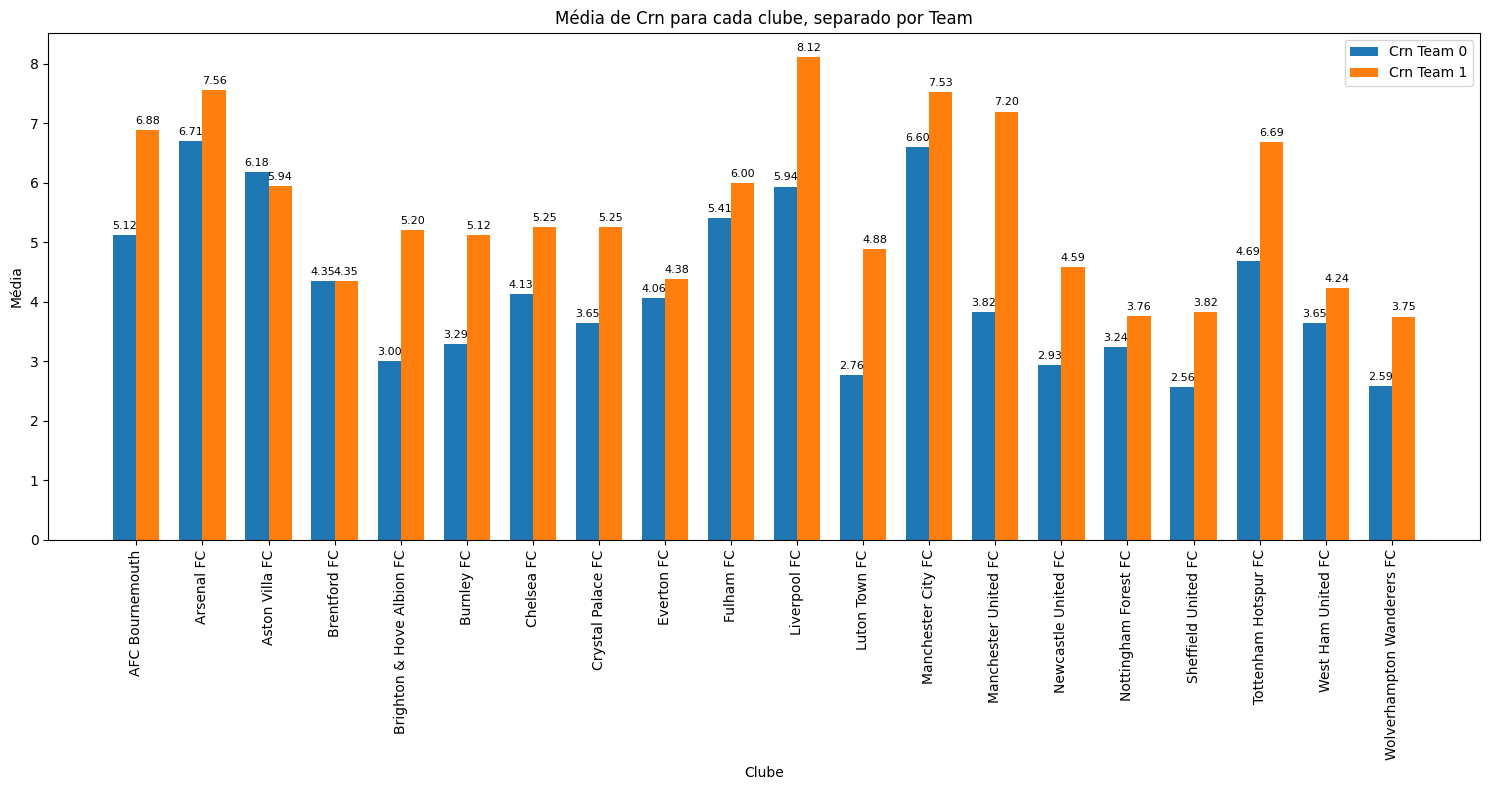

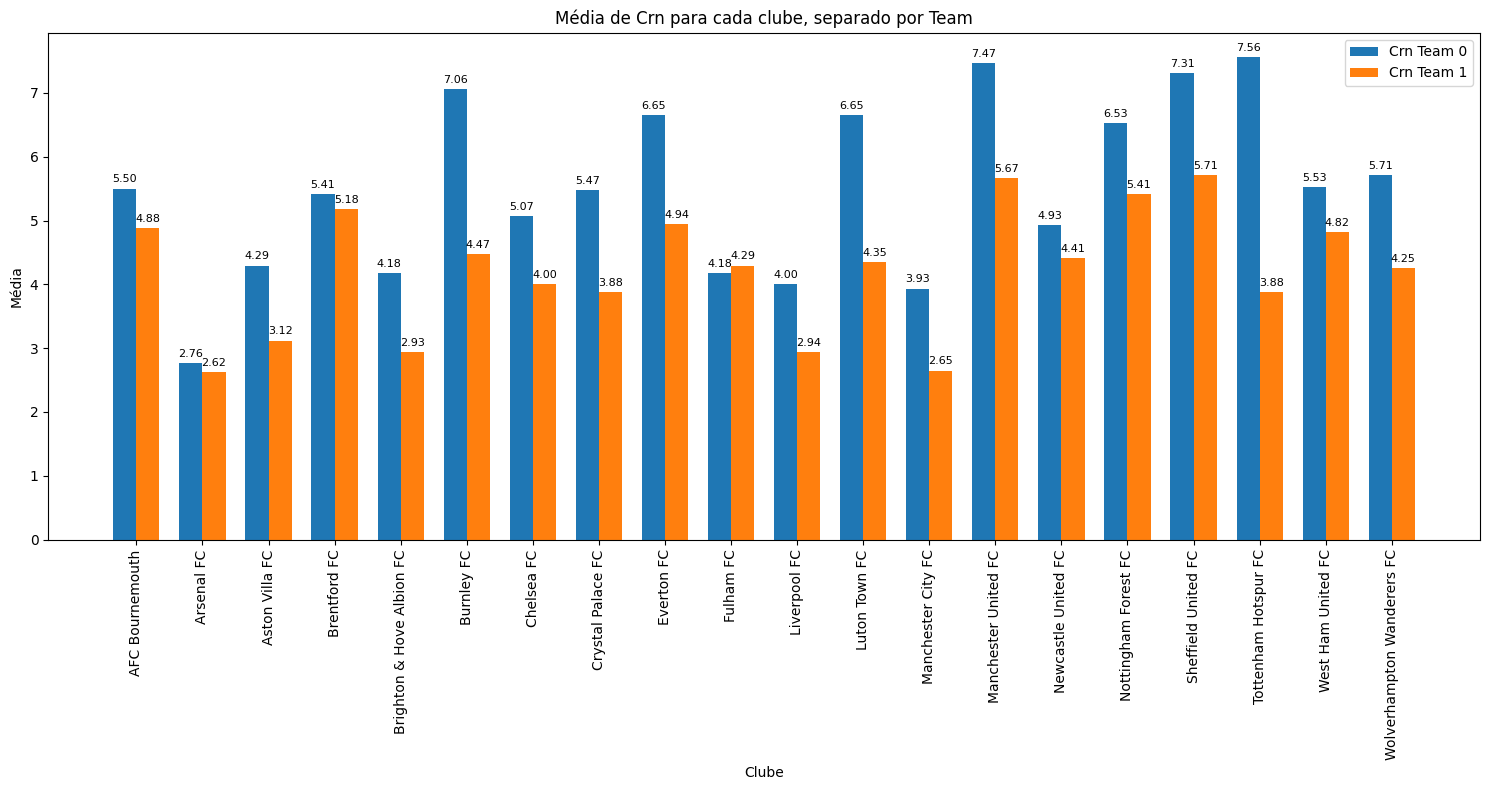

In [34]:
plot_media_por_clube(dados_clubes_pro, 'Crn')
plot_media_por_clube(dados_clubes_against, 'Crn')

In [3]:
arquivos_csv = [arquivo for arquivo in os.listdir() if arquivo.endswith('.csv')]

dados_concatenados = pd.DataFrame()

for arquivo in arquivos_csv:

    dados = pd.read_csv(arquivo)
    
    dados_concatenados = pd.concat([dados_concatenados, dados], ignore_index=True)

dados_concatenados.drop(columns=['Unnamed: 0'], inplace=True)

dados_concatenados = dados_concatenados.dropna()

dados_concatenados.reset_index(drop=True, inplace=True)

dados_concatenados

,Player,G,A,RC,YC,Crn,S,SOnT,BS,P,C,Tk,O,FC,FW,Team,Club
0,S. Longstaff,1,0,0,1,0,2,1,0,46,1,0,0,0,3,1.0,Newcastle United FC
1,D. Burn,0,0,0,0,0,0,0,0,49,0,3,0,0,0,1.0,Newcastle United FC
2,J. Murphy,1,2,0,0,3,2,2,0,35,5,0,0,0,1,1.0,Newcastle United FC
3,A. Gordon,1,0,0,0,0,2,1,0,26,0,0,0,0,1,1.0,Newcastle United FC
4,J. Lascelles,0,0,0,0,0,0,0,0,95,0,0,0,3,0,1.0,Newcastle United FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,A. Ahmedhodžić,0,0,0,0,0,0,0,0,22,0,3,0,2,0,0.0,Sheffield United FC
8332,O. McBurnie,0,0,1,2,0,2,1,1,34,0,2,1,3,3,0.0,Sheffield United FC
8333,C. Archer,0,0,0,1,0,0,0,0,21,0,1,1,1,1,0.0,Sheffield United FC
8334,O. Norwood,0,0,0,0,0,1,1,0,7,0,4,0,0,0,0.0,Sheffield United FC


## Abordagem jogadores

In [55]:
arquivos_csv = [arquivo for arquivo in os.listdir() if arquivo.endswith('.csv')]

dados_players = pd.DataFrame()

for arquivo in arquivos_csv:
    dados = pd.read_csv(arquivo)
    dados = dados.dropna()

    dados_players = pd.concat([dados_players, dados], ignore_index=True)

dados_players.reset_index(drop=True, inplace=True)

df_grouped = dados_players.groupby(["Player", "Team", "Club"]).sum().reset_index()

columns_order = ["Player", "Club", "Team"] + [col for col in ["G", "A", "RC", "YC", "Crn", "S", "SOnT", "BS", "P", "C", "Tk", "O", "FC", "FW"]]
df_grouped = df_grouped[columns_order]


df_grouped.head(6)

,Player,Club,Team,G,A,RC,YC,Crn,S,SOnT,BS,P,C,Tk,O,FC,FW
0,A. Ahmedhodžić,Sheffield United FC,0.0,0,0,0,3,3,6,1,3,360,3,24,2,12,2
1,A. Ahmedhodžić,Sheffield United FC,1.0,1,0,0,6,3,10,3,1,469,2,32,0,19,9
2,A. Areola,West Ham United FC,0.0,0,0,0,0,0,0,0,0,283,0,1,0,1,1
3,A. Areola,West Ham United FC,1.0,0,0,0,1,0,0,0,0,339,0,0,0,1,1
4,A. Ben Slimane,Sheffield United FC,0.0,0,0,0,0,1,2,1,0,81,0,6,2,5,3
5,A. Ben Slimane,Sheffield United FC,1.0,1,0,0,2,1,4,2,0,35,0,4,0,1,2


In [63]:
def filter_and_sort_df(df, club, team):
    filtered_df = df.loc[(df["Club"] == club) & (df["Team"] == team)].sort_values(by='Crn', ascending=False)
    
    # Plotando o gráfico de barras
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(filtered_df['Player'], filtered_df['Crn'])
    
    # Adicionando rótulos de valor nas barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    
    # Definindo os rótulos e título
    ax.set_xlabel('Jogador')
    ax.set_ylabel('Crn')
    ax.set_title(f'Resultados de Crn por jogador - {club} (Team {team})')
    
    # Rotacionando os rótulos do eixo x para facilitar a leitura
    plt.xticks(rotation=90)
    
    # Exibindo o gráfico
    plt.tight_layout()
    plt.show()


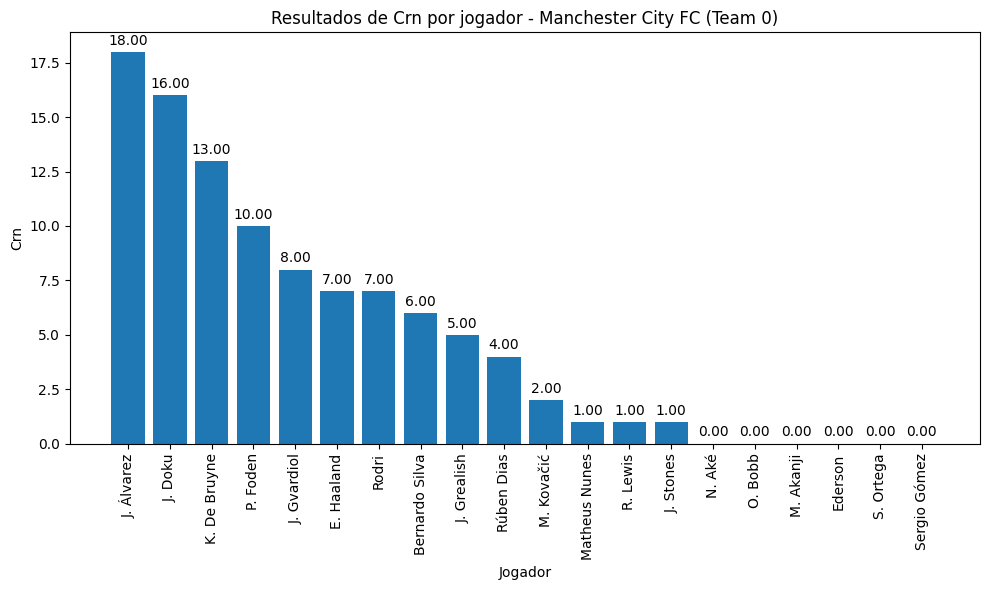

In [64]:
filter_and_sort_df(df_grouped, "Manchester City FC", 0)

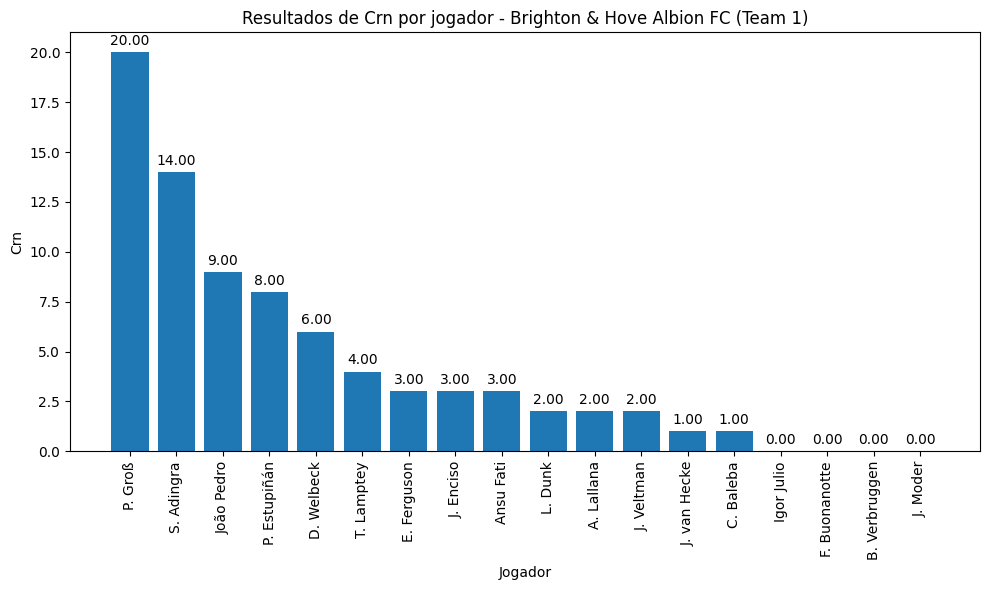

In [65]:
filter_and_sort_df(df_grouped, "Brighton & Hove Albion FC", 1)